In [42]:
import pandas as pd
import seaborn as sns

# Настройка стиля графиков
sns.set(style="whitegrid", palette="pastel", font_scale=1.1)

# Загрузка данных
df = pd.read_excel('02.2023_participant.data.xlsx')

# Целевые диагнозы
target_diagnoses = [
    "schizotypal.disorder",
    "schizophrenia",
    "schizoaffective.disorder"
]

# Отбор групп
control_group = df[
    (df['group'] == 'control') &
    (df['depression.symptoms'].isin([0, 1]))
]

patient_group = df[
    (df['group'] == 'patient') &
    (df['diagnosis'].isin(target_diagnoses))
]

# Объединение
selected_data = pd.concat([control_group, patient_group], ignore_index=True)


In [64]:
group_counts = selected_data['group'].value_counts()
print(group_counts)

group
control    103
patient     72
Name: count, dtype: int64


In [43]:
selected_data.head()

,ID,group,diagnosis,sex,age,education.level,education.years,depression.symptoms,thought.disorder.symptoms
0,PN-001,control,NaN,male,27,higher,22,0,0
1,PN-002,control,NaN,female,36,higher,17,0,0
2,PN-003,control,NaN,female,27,higher,18,0,0
3,PN-004,control,NaN,male,20,higher,14,0,0
4,PN-005,control,NaN,female,21,higher,14,0,0


# Получение аудио

In [60]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
import os

gauth = GoogleAuth()
gauth.CommandLineAuth()

drive = GoogleDrive(gauth)

# ID папки на Google Диске
folder_id = '1-zZnxWU4tSuSMYalaHZJ37rQxfJIhYeq'  

# Папка для загрузки
download_folder = 'downloaded_audio'
os.makedirs(download_folder, exist_ok=True)

# Список ID участников 
participant_ids = selected_data['ID']

# Допустимые расширения аудиофайлов
audio_extensions = ['.wav', '.mp3', '.m4a', '.flac', '.aac', '.ogg']

# Получение списка файлов из папки
file_list = drive.ListFile({
    'q': f"'{folder_id}' in parents and trashed=false"
}).GetList()

# Загрузка подходящих аудиофайлов
for file in file_list:
    file_name = file['title']
    if any(file_name.lower().endswith(ext) for ext in audio_extensions) and \
       any(pid in file_name for pid in participant_ids):
        #print(f"Скачивается: {file_name}")
        file.GetContentFile(os.path.join(download_folder, file_name))

print("Все подходящие аудиофайлы загружены.")


Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?client_id=211037828478-2atbkm1qk3v6aonfgqq3p30d0hn00b9v.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline&response_type=code



Enter verification code:  4/1AUJR-x6yL6KdJQhXIiBy0i4uBFmuOwg38L8f4a7rGXiVjQsIu0ETYN2bpds


Authentication successful.
Все подходящие аудиофайлы загружены.


# Проверка файлов

In [63]:
import os
from collections import defaultdict

# Путь к директории с аудиофайлами
directory = './downloaded_audio/'

# Словари для хранения данных
formats = set()
patient_files_count = defaultdict(int)
control_files_count = defaultdict(int)

# Получаем список всех файлов в директории
for filename in os.listdir(directory):
    if os.path.isfile(os.path.join(directory, filename)):
        ext = filename.split('.')[-1]
        formats.add(ext)

        # Определяем к какой группе относится файл по префиксу
        if filename.startswith('PD'):
            patient_id = filename.split('-')[1]
            patient_files_count[patient_id] += 1
        elif filename.startswith('PN'):
            control_id = filename.split('-')[1]
            control_files_count[control_id] += 1

# Выводим все форматы
print("Все встречающиеся форматы файлов:", formats)

# Количество файлов на каждого пациента и контрольного субъекта
# print("\nФайлы на каждого пациента (PD):")
# for patient, count in patient_files_count.items():
#     print(f"Пациент {patient}: {count} файлов")

# print("\nФайлы на каждого контрольного субъекта (PN):")
# for control, count in control_files_count.items():
#     print(f"Контроль {control}: {count} файлов")

# Общее количество файлов в каждой группе
total_patients_files = sum(patient_files_count.values())
total_controls_files = sum(control_files_count.values())
print(f"\nОбщее количество файлов у пациентов: {total_patients_files}")
print(f"Общее количество файлов у контрольной группы: {total_controls_files}")

# Размах по количеству файлов (min, max) для пациентов и контроля
if patient_files_count:
    patient_min = min(patient_files_count.values())
    patient_max = max(patient_files_count.values())
    print(f"Размах количества файлов у пациентов: от {patient_min} до {patient_max}")
else:
    print("Нет данных по пациентам.")

if control_files_count:
    control_min = min(control_files_count.values())
    control_max = max(control_files_count.values())
    print(f"Размах количества файлов у контрольной группы: от {control_min} до {control_max}")
else:
    print("Нет данных по контрольной группе.")


Все встречающиеся форматы файлов: {'wav'}

Общее количество файлов у пациентов: 238
Общее количество файлов у контрольной группы: 330
Размах количества файлов у пациентов: от 1 до 4
Размах количества файлов у контрольной группы: от 2 до 6


# Описательная статистика

In [44]:
from scipy.stats import shapiro, mannwhitneyu, chi2_contingency

def analyze_numeric_vars(data, variables):
    groups = data['group'].unique()
    for var in variables:
        print(f"Анализ числовой переменной: {var}")
        control = data[data['group'] == 'control'][var].dropna()
        patient = data[data['group'] == 'patient'][var].dropna()

        control_mean, control_std = control.mean(), control.std()
        patient_mean, patient_std = patient.mean(), patient.std()

        print(f"Control: mean = {control_mean:.2f}, SD = {control_std:.2f}")
        print(f"Patient: mean = {patient_mean:.2f}, SD = {patient_std:.2f}")

        if control.nunique() > 1:
            shapiro_p_control = shapiro(control).pvalue
            print(f"Shapiro-Wilk test p-value (control): {shapiro_p_control:.3f}")
        else:
            shapiro_p_control = None
            print("Control group для переменной {var} не имеет разброса, тест Шапиро не применим.")

        shapiro_p_patient = shapiro(patient).pvalue
        print(f"Shapiro-Wilk test p-value (patient): {shapiro_p_patient:.3f}")

        u_stat, p_value = mannwhitneyu(control, patient, alternative='two-sided')
        print(f"Mann-Whitney U test: statistic = {u_stat:.3f}, p-value = {p_value:.3f}")
        if p_value < 0.05:
            print("Результат: значимое различие между группами (p < 0.05)\n")
        else:
            print("Результат: значимых различий между группами не обнаружено (p >= 0.05)\n")


def analyze_categorical_vars(data, variables):
    for var in variables:
        print(f"Анализ категориальной переменной: {var}")
        contingency_table = pd.crosstab(data['group'], data[var])
        print("Таблица частот:")
        print(contingency_table)

        chi2, p_value, _, _ = chi2_contingency(contingency_table)
        print(f"Chi-square test: p-value = {p_value:.3f}")
        if p_value < 0.05:
            print("Результат: значимое различие распределения категорий между группами (p < 0.05)\n")
        else:
            print("Результат: значимых различий распределения категорий не обнаружено (p >= 0.05)\n")


In [45]:
numeric_vars = ['age', 'depression.symptoms', 'thought.disorder.symptoms', 'education.years']
categorical_vars = ['diagnosis', 'sex', 'education.level']

analyze_numeric_vars(selected_data, numeric_vars)
analyze_categorical_vars(selected_data, categorical_vars)


Анализ числовой переменной: age
Control: mean = 28.00, SD = 10.84
Patient: mean = 24.72, SD = 6.90
Shapiro-Wilk test p-value (control): 0.000
Shapiro-Wilk test p-value (patient): 0.000
Mann-Whitney U test: statistic = 4429.500, p-value = 0.028
Результат: значимое различие между группами (p < 0.05)

Анализ числовой переменной: depression.symptoms
Control: mean = 0.34, SD = 0.48
Patient: mean = 0.43, SD = 0.65
Shapiro-Wilk test p-value (control): 0.000
Shapiro-Wilk test p-value (patient): 0.000
Mann-Whitney U test: statistic = 3559.000, p-value = 0.588
Результат: значимых различий между группами не обнаружено (p >= 0.05)

Анализ числовой переменной: thought.disorder.symptoms
Control: mean = 0.00, SD = 0.00
Patient: mean = 0.43, SD = 0.60
Control group для переменной {var} не имеет разброса, тест Шапиро не применим.
Shapiro-Wilk test p-value (patient): 0.000
Mann-Whitney U test: statistic = 2317.500, p-value = 0.000
Результат: значимое различие между группами (p < 0.05)

Анализ числовой п

# Визуализация

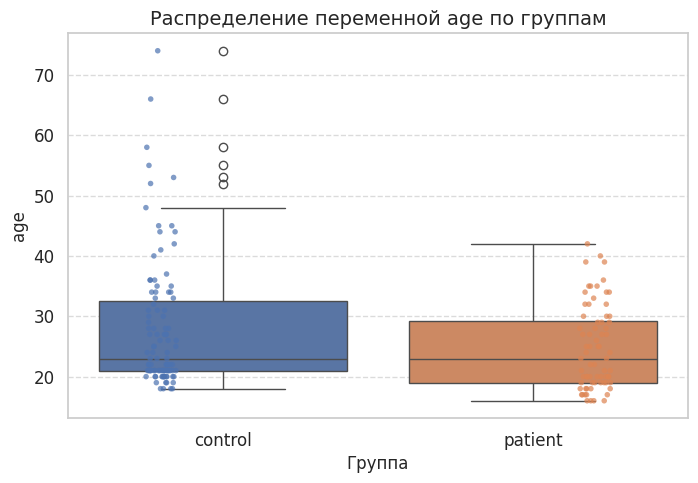

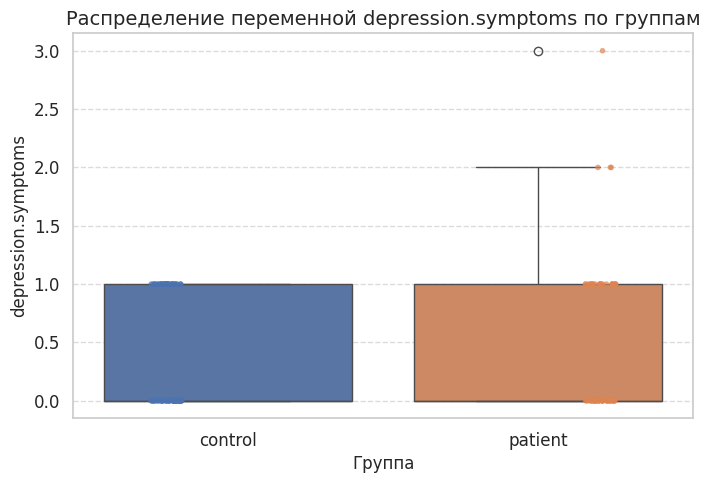

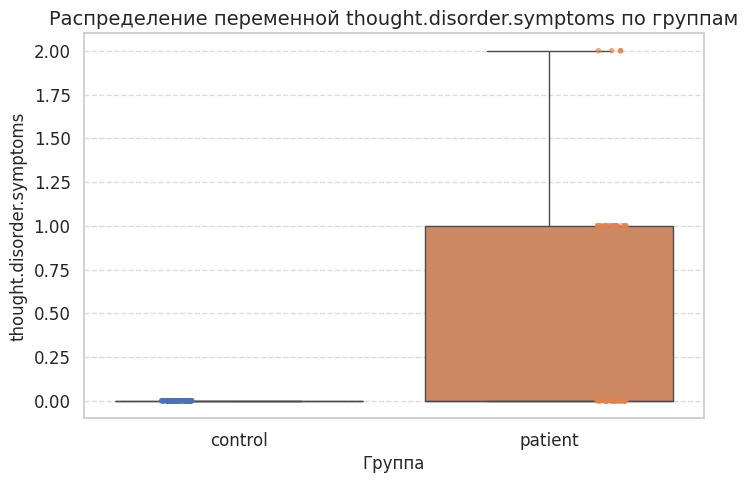

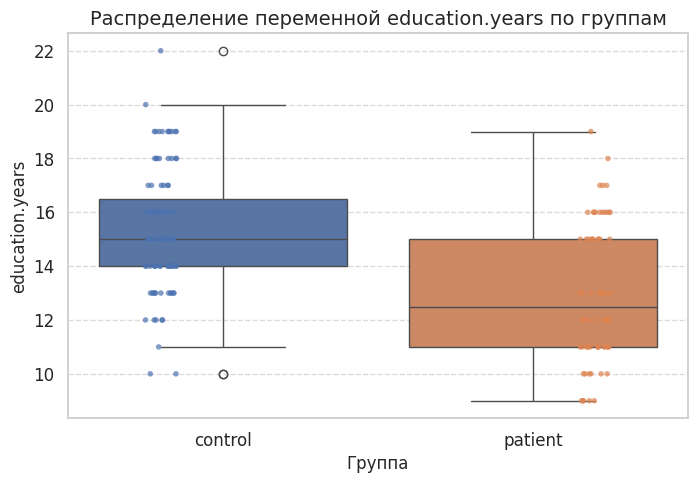

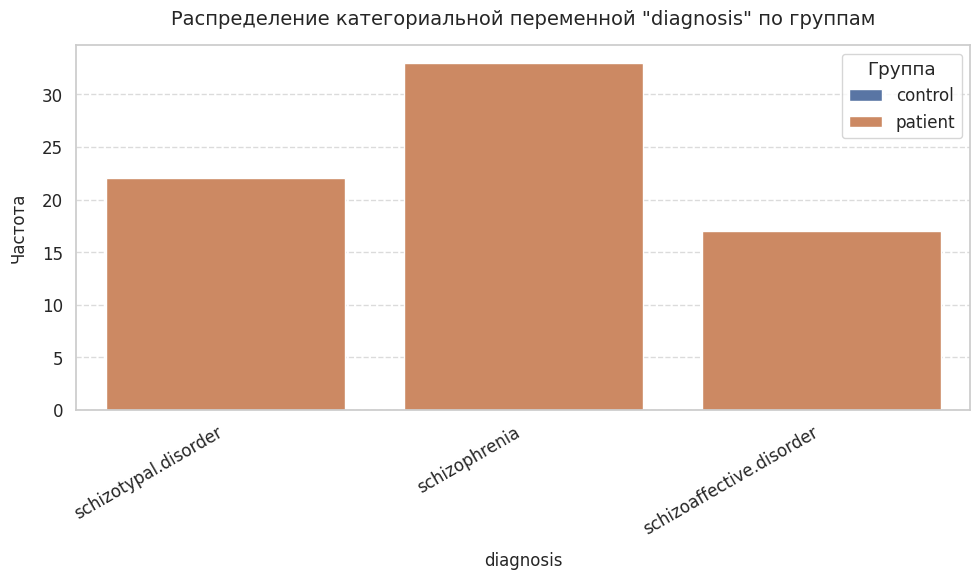

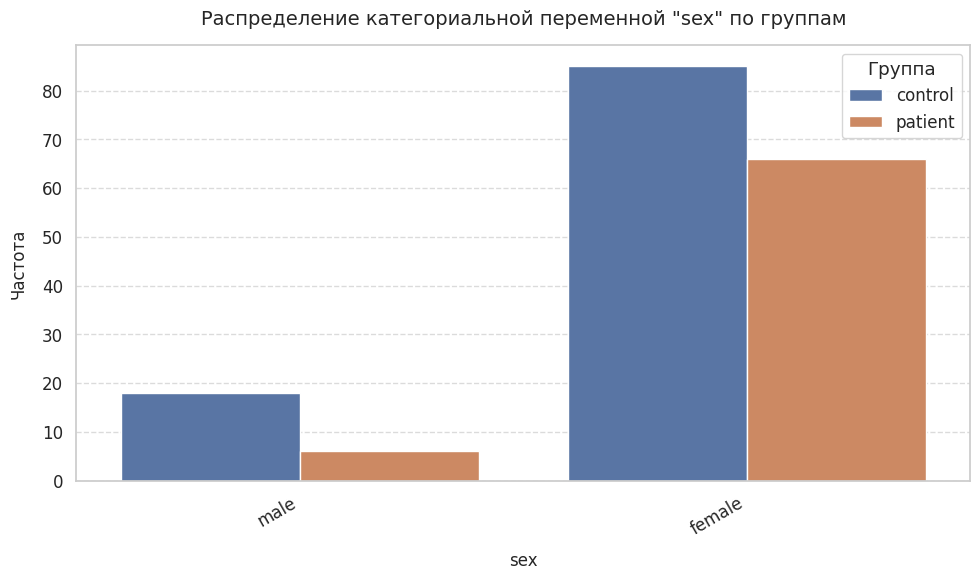

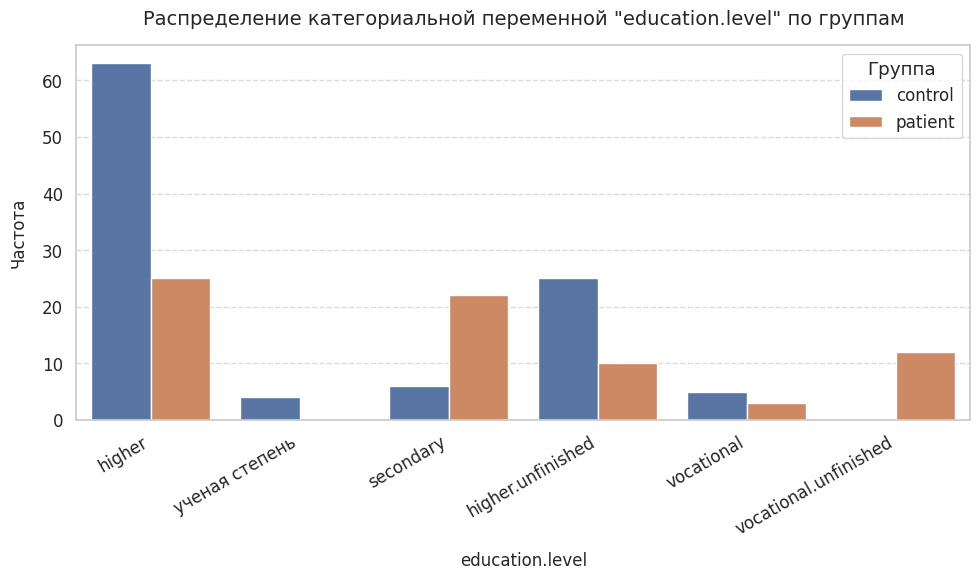

In [46]:
import matplotlib.pyplot as plt

sns.set_palette("deep")

def plot_numeric_vars(df, numeric_vars, group_col='group'):
    for var in numeric_vars:
        plt.figure(figsize=(8, 5))
        sns.boxplot(x=group_col, y=var, data=df, hue=group_col, legend=False)
        sns.stripplot(x=group_col, y=var, data=df, hue=group_col,
                      size=4, jitter=True, alpha=0.7, dodge=True, legend=False)
        plt.title(f'Распределение переменной {var} по группам', fontsize=14)
        plt.xlabel('Группа', fontsize=12)
        plt.ylabel(var, fontsize=12)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()

def plot_categorical_vars(df, categorical_vars, group_col='group'):
    for var in categorical_vars:
        plt.figure(figsize=(10, 6))
        sns.countplot(x=var, hue=group_col, data=df)
        plt.title(f'Распределение категориальной переменной "{var}" по группам', fontsize=14, pad=15)
        plt.xlabel(var, fontsize=12, labelpad=10)
        plt.ylabel('Частота', fontsize=12, labelpad=10)
        plt.xticks(rotation=30, ha='right')  
        plt.legend(title='Группа', loc='upper right')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()  
        plt.show()

plot_numeric_vars(selected_data, numeric_vars)
plot_categorical_vars(selected_data, categorical_vars)
